# Attention meets XAI 

## Different explainers can produce very different explanations

Generates Figure 1 of the paper *Attention Meets Post-hoc Interpretability: A Mathematical Perspective*. 

In [1]:
import os
import pickle
import itertools 

import torch
import numpy as np
import math
import re

from lime import lime_text

In [2]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from matplotlib import transforms
import matplotlib.pyplot as plt

In [3]:
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)
plt.rcParams.update({'font.size': 18})

In [4]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
import sys
sys.path.append("C:/Users/gianl/Anaconda3/bin")

In [6]:
from models.utils import get_g_values
from models.utils import scaled_dot_product
from data.dataset import Dataset
import params

In [7]:
from utils.plots import plot_exp

In [8]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model name and path
model_name = 'multi_head_e\\model'
model_path = os.path.join('.', 'models', 'saved', 'IMDB', model_name)

# Load the classifier model
with open(os.path.join(model_path, 'classifier.pkl'), 'rb') as inp:
    classifier = pickle.load(inp)
print(f"Model loaded successfully from: {model_path}")

Using device: cpu
Model loaded successfully from: .\models\saved\IMDB\multi_head_e\model


In [9]:
example = "attention based explanations are popular but questionable"

tokens = classifier.tokenizer(example)

In [10]:
print(example)
print(f'Prediction: {classifier.predict_proba([example])}')

attention based explanations are popular but questionable
Prediction: [[-0.64168686  0.58398646]]


# Explanations

## Attention

### Average

In [11]:
_, _, _, attn_exp = classifier.get_attention_exp(example, option='avg')
print(attn_exp)

{'popular': 0.13757623732089996, 'questionable': 0.10408841818571091, 'based': 0.07760432362556458, 'explanations': 0.05953999236226082, 'but': 0.03555268421769142, 'are': 0.014360223896801472, 'attention': 0.01219672430306673}


### Max

In [12]:
_, _, _, attn_max_exp = classifier.get_attention_exp(example, option='max')
print(attn_max_exp)

{'popular': 0.7247000336647034, 'questionable': 0.31604811549186707, 'based': 0.24733403325080872, 'explanations': 0.24306632578372955, 'but': 0.1136535033583641, 'are': 0.0641089454293251, 'attention': 0.05362429842352867}


## LIME

In [13]:
lime_explainer = lime_text.LimeTextExplainer(class_names=['negative', 'positive'], mask_string=params.MASK, 
                                             # split_expression=classifier.tokenizer
                                            )
lime_exp_mh = lime_explainer.explain_instance(example, classifier.predict_proba, num_features=params.MAX_LEN)
lime_exp = dict(sorted(dict(lime_exp_mh.as_list()).items(), key=lambda x: x[1], reverse=True))
print(lime_exp)

{'popular': 0.235757339326017, 'are': -0.008930935648339028, 'explanations': -0.03887063225128187, 'attention': -0.07733145780027975, 'based': -0.2114407390394597, 'but': -0.32516291933583663, 'questionable': -1.0116138921266682}


## Gradient 

### Mean

In [14]:
gradient, gradient_mean_exp = classifier.get_gradient_exp(example, option='mean')
print(gradient_mean_exp)

{'popular': 0.001740956911817193, 'based': 0.0015463110757991672, 'attention': -0.00026588496984913945, 'explanations': -0.0004182897391729057, 'are': -0.0007766992202959955, 'but': -0.002806743374094367, 'questionable': -0.008211946114897728}


### L2

In [15]:
gradient, gradient_l2_exp = classifier.get_gradient_exp(example, option='l2')
print(gradient_l2_exp)

{'questionable': 1.331404447555542, 'based': 0.37513384222984314, 'popular': 0.35183799266815186, 'explanations': 0.2669317126274109, 'but': 0.25564855337142944, 'are': 0.056486066430807114, 'attention': 0.04051807150244713}


### L1 

In [16]:
gradient, gradient_l1_exp = classifier.get_gradient_exp(example, option='l1')
print(gradient_l1_exp)

{'questionable': 11.99755573272705, 'based': 3.392225980758667, 'popular': 3.2402589321136475, 'explanations': 2.458035945892334, 'but': 2.270643472671509, 'are': 0.5111727714538574, 'attention': 0.3554685413837433}


## Gradient$\times$Input

In [17]:
gradient, gradient_xinput_exp = classifier.get_gradient_exp(example, option='xInput')
print(gradient_xinput_exp)

{'popular': 0.28014135360717773, 'are': -0.014015511609613895, 'attention': -0.019129177555441856, 'explanations': -0.21370720863342285, 'based': -0.3420998752117157, 'but': -0.6027553677558899, 'questionable': -3.33164644241333}


# Visualize

In [18]:
res_path = os.path.join('results', 'paper', 'qualitative')
if not os.path.exists(res_path):
    os.makedirs(res_path)

Attention - average over heads


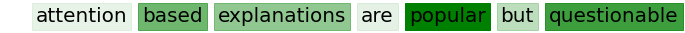

In [19]:
print('Attention - average over heads')
plot_exp(attn_exp, tokens, save=os.path.join(res_path, 'attention.pdf'))

Attention - maximum over heads


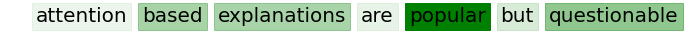

In [20]:
print('Attention - maximum over heads')
plot_exp(attn_max_exp, tokens, save=os.path.join(res_path, 'attention_max.pdf'))

LIME


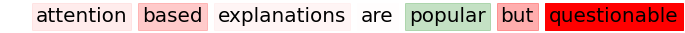

In [21]:
print('LIME')
plot_exp(lime_exp, tokens, save=os.path.join(res_path, 'lime.pdf'))

Gradient Mean


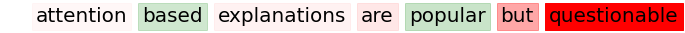

In [22]:
print('Gradient Mean')
plot_exp(gradient_mean_exp, tokens, save=os.path.join(res_path, 'gradient_mean.pdf'))

Gradient L1


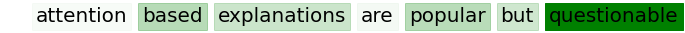

In [23]:
print('Gradient L1')
plot_exp(gradient_l1_exp, tokens, save=os.path.join(res_path, 'gradient_l1.pdf'))

Gradient L2


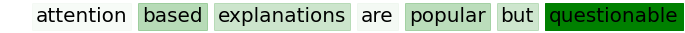

In [24]:
print('Gradient L2')
plot_exp(gradient_l2_exp, tokens, save=os.path.join(res_path, 'gradient_l2.pdf'))

Gradient x Input


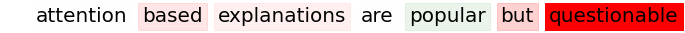

In [25]:
print('Gradient x Input')
plot_exp(gradient_xinput_exp, tokens, save=os.path.join(res_path, 'gradient_input.pdf'))